In [84]:
import pandas as pd
import talib as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import logging
from typing import Dict, Any
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
DataFrame = pd.DataFrame
logging.basicConfig(level=logging.INFO)

In [85]:
def preprocess_data(data:pd.DataFrame):
    # 生成技术指标
    data['SMA'] = data['close'].rolling(window=20).mean()
    data['EMA20'] = data['close'].ewm(span=20, adjust=False).mean()
    data['MACD'] = data['close'].ewm(span=12, adjust=False).mean() - data['close'].ewm(span=26, adjust=False).mean()
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['Signal']
    data['RSI'] = ta.RSI(data['close'], timeperiod=14)
    data['UpperBB'],data['MiddleBB'],data['LowerBB'] = ta.BBANDS(data['close'], timeperiod=20)
    data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=14)
    data['Volatility'] = data['ATR'] / data['close']
    sns.pairplot(data[["MACD", "close"]], diag_kind="kde")

    sns.pairplot(data[["RSI", "close"]], diag_kind="kde")
    return data.sort_values(by='date', ascending=True).dropna()

In [86]:
def create_features(data:DataFrame, lookahead = 5):
    # 特征工程
    for lag in [1, 3, 5]:
        data[f'return_lag{lag}'] = data['close'].pct_change(lag)
    # 添加技术指标交叉信号
    data['MACD_cross'] = np.where(data['MACD'] > data['Signal'], 1, -1)
    data['BB_width'] = (data['UpperBB'] - data['LowerBB']) / data['MiddleBB']
    # 严格时序特征生成
    data['future_return'] = data['close'].pct_change(lookahead).shift(-lookahead -1)

    data['log_return'] = np.log(data['close']).diff()
    data['volatility_30'] = data['log_return'].rolling(30).std()
    # 新增时间序列特征
    data['month'] = data.index.month
    data['day_of_week'] = data.index.dayofweek

    # 特征选择
    selected_features = ['RSI', 'MACD','Signal', 'volatility_30',  'UpperBB', 'MiddleBB', 'LowerBB', 'BB_width',
                        'return_lag1', 'return_lag3', 'month']
    data['return'] = data['close'].pct_change()
    # 确保时间对齐
    data = data.dropna()
    
    return  data[selected_features], data['future_return']

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense

# from transformer import TransformerEncoder  # 需要自定义或使用现有实现
tf.config.list_physical_devices('GPU')
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training=False):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, self.d_model, 2, dtype=tf.float32) * 
                        (-tf.math.log(10000.0) / self.d_model))
        
        pe = tf.zeros((1, seq_len, tf.cast(self.d_model, tf.int32)))
        pe = tf.Variable(pe)
        pe[:, :, 0::2].assign(tf.sin(position * div_term))
        pe[:, :, 1::2].assign(tf.cos(position * div_term))
        return inputs + pe.value

In [ ]:
def get_model_configs() -> Dict[str, Dict[str, Any]]:
    """统一管理模型配置"""
    return {
        'random_forest': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor())
            ]),
            'param_grid': {
                'regressor__n_estimators': [100, 200],
                'regressor__max_depth': [5, 8]
            }
        },
        'xgb': {
            'pipeline': Pipeline([
                ('scaler', RobustScaler()),
                ('regressor', XGBRegressor(
                    objective='reg:squarederror', 
                    n_jobs=-1
                ))
            ]),
            'param_grid': {
                'regressor__learning_rate': [0.005, 0.01, 0.05],
                'regressor__max_depth': [3, 5, 7],
                'regressor__subsample': [0.6, 0.8],
                'regressor__colsample_bytree': [0.7, 0.9],
                'regressor__n_estimators': [200, 300]
            }
        },
        'lstm': {
            'seq_length': 30,
            'params': {
                'units': 128,
                'dropout': 0.2,
                'learning_rate': 1e-3,
                'batch_size': 64,
                'epochs': 100
            }
        },
        'transformer': {
            'seq_length': 30,
            'params': {
                'd_model': 64,
                'num_heads': 4,
                'ff_dim': 128,
                'num_layers': 2,
                'dropout': 0.1,
                'learning_rate': 1e-4,
                'batch_size': 32,
                'epochs': 200
            }
        }
    }
def create_sequences(data, seq_length):
    """创建时间序列样本"""
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape, params):
    """构建LSTM模型"""
    model = Sequential([
        LSTM(params['units'], input_shape=input_shape, return_sequences=True),
        Dropout(params['dropout']),
        LSTM(params['units']),
        Dropout(params['dropout']),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model

def build_transformer_model(input_shape, params):
    """构建Transformer模型"""
    inputs = tf.keras.Input(shape=input_shape)
    
    # 位置编码层
    x = PositionalEncoding(params['d_model'])(inputs)
    
    # # Transformer编码层
    for _ in range(params['num_layers']):
        x = TransformerEncoder(params['d_model'], params['num_heads'], params['ff_dim'])(x)
    
    # 全局平均池化 + 输出层
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model

class TimeSeriesModel(BaseEstimator):
    """统一时序模型接口"""
    def __init__(self, model_type='lstm', **params):
        self.model_type = model_type
        self.params = params
        self.model = None
        self.val_performance = {}
        self.performance = {}

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds

    def fit(self, X, y):
        # 数据预处理
        seq_length = self.params['seq_length']
        X_seq, y_seq = create_sequences(X.values, seq_length)
        
        # 构建模型
        if self.model_type == 'lstm':
            self.model = build_lstm_model((seq_length, X.shape[1]), self.params)
        elif self.model_type == 'transformer':
            self.model = build_transformer_model((seq_length, X.shape[1]), self.params)
        
        # 训练
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        self.history = self.model.fit(
            X_seq, y_seq,
            batch_size=self.params['batch_size'],
            epochs=self.params['epochs'],
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )

        self.val_performance['Linear'] = self.model.evaluate(single_step_window.val)
        self.performance['Linear'] = self.model.evaluate(single_step_window.test, verbose=0)
        return self
    
    def predict(self, X):
        return self.model.predict(X).flatten()

In [89]:
from sklearn.ensemble import StackingRegressor
def cross_validate_model(
    model: BaseEstimator,
    param_grid: Dict[str, Any],
    X: pd.DataFrame,
    y: pd.Series,
    tscv: TimeSeriesSplit
) -> Dict[str, Any]:
    """通用交叉验证流程"""

    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'cv_results': grid_search.cv_results_
    }

In [90]:
def analyze_features(model, feature_names):
    """可视化特征重要性"""
    plt.figure(figsize=(10,6))
    try:
         # 兼容不同模型结构
        if hasattr(model.named_steps['regressor'], 'feature_importances_'):
            importance = pd.Series(model.named_steps['regressor'].feature_importances_,index=feature_names).sort_values()

        elif hasattr(model.named_steps['regressor'], 'coef_'):
            importance = np.abs(model.named_steps['regressor'].coef_)
        else:
            raise AttributeError("模型不支持特征重要性分析")
                
        importance.plot(kind='barh', title='Feature Importance')
        plt.show()
    except Exception as e:
        logging.error(f"特征分析失败: {str(e)}")

In [ ]:
def train_models(X, y):
    """多模型集成训练入口"""
    tscv = TimeSeriesSplit(n_splits=5, test_size=30)
    model_configs = get_model_configs()
    # estimators = [
    #     ('rf', model_configs['random_forest']['pipeline']),
    #     ('xgb', model_configs['xgb']['pipeline'])
    # ]

    # stacking = StackingRegressor(
    #     estimators=estimators,
    #     final_estimator=XGBRegressor(),
    #     cv=tscv
    # )
    results = {}
    for model_name, config in model_configs.items():
        if model_name in ['lstm', 'transformer']:
            # 深度学习模型训练
            model = TimeSeriesModel(model_name, **config['params'])
            model.fit(X, y)
            results[model_name] = {
                'model': model,
                'history': model.history
            }
        else: # 普通机器学习模型训练
            model_result = cross_validate_model(
                config['pipeline'],
                config['param_grid'],
                X, y, tscv
            )
            # 保存基准分数到模型对象
            model_result['best_model'].baseline_score = model_result['cv_results']['mean_test_score'].max()
            # 存储每个模型的最佳结果
            results[model_name] = {
                'model': model_result['best_model'],
                'params': model_result['best_params'],
                'cv_score': model_result['cv_results']['mean_test_score'].max()
            }
            # 新增特征分析
            analyze_features(
                model_result['best_model'],
                feature_names=X.columns.tolist()
            )
            print(f"{model_name.upper()} 最佳参数: {model_result['best_params']}")
            print(f"平均验证得分: {model_result['cv_results']['mean_test_score'].max():.3f}")
    # 为集成模型创建基准分数（取各模型平均）
    ensemble_baseline = np.mean([results[model]['cv_score'] for model in results])
    ensemble = VotingRegressor(
        [(name, results['model']) for name, results in results.items()]
    )
    ensemble.baseline_score = ensemble_baseline  # 添加基准分数属性
    return ensemble

In [92]:
def track_model_drift(model, X: pd.DataFrame, y: pd.Series, n_folds: int = 5) -> float:
    """监控模型性能漂移
    Args:
        model: 已训练的基准模型
        X: 新数据特征
        y: 新数据目标值
        n_folds: 交叉验证折数
    
    Returns:
        当前分数与基准分数的差值
    """
    try:
        current_score = cross_val_score(model, X, y, cv=5).mean()
        baseline_score = model.baseline_score  # 从保存的基准模型中读取
    except Exception as e:
        logging.error(f"漂移检测失败: {str(e)}")
        return np.nan
    # 从已保存的基准模型读取历史分数
    baseline_score = getattr(model, 'baseline_score', None)
    if baseline_score is None:
        baseline_score = current_score
        logging.warning("未找到基准分数，使用当前分数作为基准")
    
    return current_score - baseline_score

In [93]:
class ModelMonitor:
    """模型监控管理器"""
    def __init__(self, baseline_model_path):
        self.baseline = joblib.load(baseline_model_path)
        self.baseline_score = self.baseline.baseline_score
        
    def check_drift(self, X_new, y_new, threshold=0.1):
        # 添加时间序列有效性验证
        if not isinstance(X_new.index, pd.DatetimeIndex):
            raise ValueError("输入数据需要包含有效时间索引")
            
        # 添加数据时效性检查（最新数据不应早于3天前）
        latest_date = X_new.index.max()
        if pd.Timestamp.now() - latest_date > pd.Timedelta(days=3):
            logging.warning("检测到过期数据：{latest_date}")

        current = cross_val_score(
            self.baseline, X_new, y_new,
            cv=TimeSeriesSplit(3),
            scoring='neg_mean_squared_error'
        ).mean()
        return (current - self.baseline_score) < threshold
    
    def plot_performance(self, historical_data):
        """性能趋势可视化"""
        plt.figure(figsize=(12,6))
        plt.plot(historical_data['dates'], historical_data['scores'], 
                label='当前表现')
        plt.axhline(self.baseline_score, color='r', 
                   linestyle='--', label='基准表现')
        plt.title('Model Performance Monitoring')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

In [94]:
from backtesting import Backtest, Strategy

class ModelDrivenStrategy(Strategy):
    """基于模型预测的交易策略"""
    # 策略参数
    threshold_entry = 0.02  # 买入阈值
    threshold_exit = -0.01  # 卖出阈值
    position_size = 0.1  # 仓位比例
    
    def init(self):
        # 加载预训练模型
        self.model = joblib.load('stock_predictor.pkl')
        
        # 初始化指标计算窗口
        self.returns = self.I(self.calculate_returns)
        
    def calculate_returns(self):
        """实时计算收益率特征"""
        close = self.data.Close.df
        return close.pct_change()
    
    def next(self):
        # 仅在有足够历史数据时交易
        if len(self.data) < 30:
            return
        
        # 构建特征数据
        current_idx = len(self.data) - 1
        features = pd.DataFrame({
            'RSI': pd.Series(self.data.RSI).iloc[-20:].mean(),
            'MACD': self.data['MACD'].iloc[-1],
            'volatility': self.data['volatility_30'].iloc[-1],
            'BB_width': self.data['BB_width'].iloc[-1],
            'return_lag1': self.returns[-1] if len(self.returns) > 0 else 0,
            'return_lag3': self.returns[-3:].mean() if len(self.returns) >=3 else 0,
            'month': self.data.index[-1].month
        }, index=[current_idx])
        
        # 模型预测
        predicted_return = self.model.predict(features)[0]
        
        # 交易逻辑
        if not self.position:
            if predicted_return > self.threshold_entry:
                self.buy(size=self.position_size)
        else:
            if predicted_return < self.threshold_exit:
                self.position.close()
def backtest(data: pd.DataFrame, ensemble, X, y, initial_capital=100000):
    """执行完整回测流程"""
    # 准备回测数据格式
    bt_data = data.rename(columns={
        'close': 'Close',
        'high': 'High',
        'low': 'Low',
        'open': 'Open'
    }).copy()
    # 添加必要字段到回测数据
    for col in ['RSI', 'MACD', 'volatility_30', 'BB_width']:
        bt_data[col] = data[col]
    # 添加衍生特征
    bt_data['return_lag1'] = bt_data['Close'].pct_change(1)
    bt_data['return_lag3'] = bt_data['Close'].pct_change(3)
    bt_data['month'] = bt_data.index.month
    # 优化参数（可选）
    # stats = bt.optimize(
    #     threshold_entry=[0.01, 0.02, 0.03],
    #     threshold_exit=[-0.01, -0.02],
    #     maximize='Sharpe Ratio'
    # )
    # 初始化回测引擎
    bt = Backtest(
        bt_data.dropna(),
        ModelDrivenStrategy,
        cash=100000,
        commission=0.001,  # 考虑交易手续费
        exclusive_orders=True
    )
    stats = bt.run()
    bt.plot(filename='backtest_result.html')
    
    # 关键指标报告
    print(f"夏普比率: {stats['Sharpe Ratio','NaN']:.2f}")
    print(f"最大回撤: {stats['Max. Drawdown','NaN']:.2%}")
    print(f"总收益率: {stats['Return [%]','NaN']:.2f}%")
    
    return stats

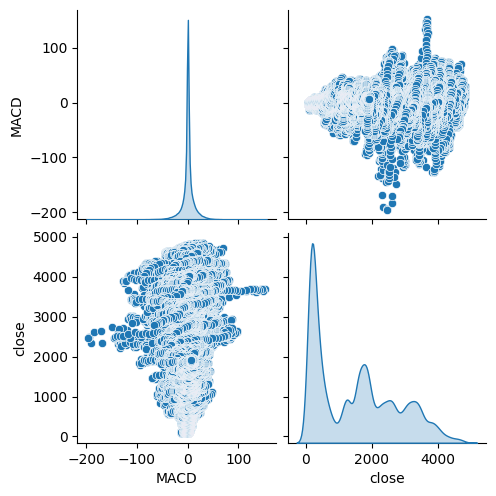

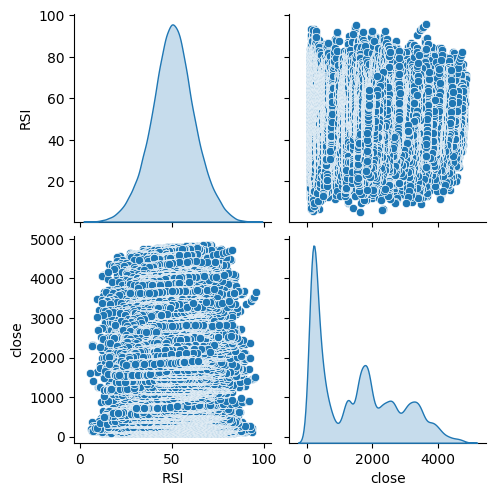

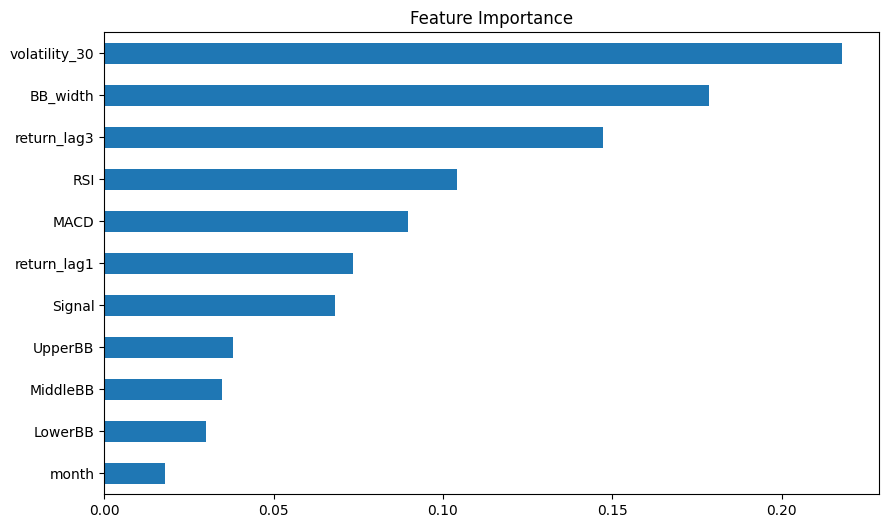

RANDOM_FOREST 最佳参数: {'regressor__max_depth': 5, 'regressor__n_estimators': 200}
平均验证得分: -0.000


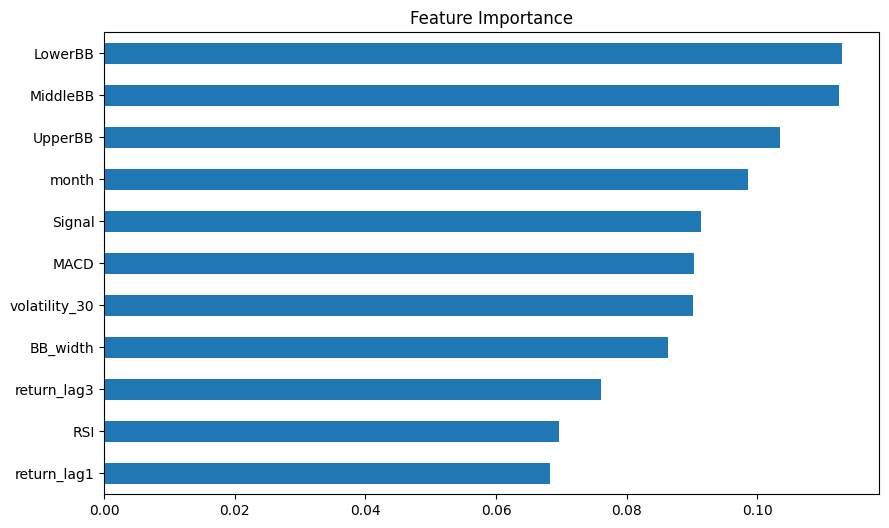

XGB 最佳参数: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__n_estimators': 300, 'regressor__subsample': 0.6}
平均验证得分: -0.000


TypeError: 'units' is an invalid keyword argument for print()

In [95]:
if __name__ == '__main__':
    data = pd.read_csv('stock.csv', index_col='date',parse_dates=True)
    data = preprocess_data(data)
    
    features, target = create_features(data)
    """训练模型"""
    ensemble = train_models(features, target)

     # 模拟新数据到来时的监控（示例）
    # new_data = pd.read_csv('new_stock_data.csv') 
    # new_features, _ = create_features(preprocess_data(new_data))
    current_drift = track_model_drift(
        ensemble,
        features.sample(1000),  # 假设取样本数据
        target.sample(1000)
    )
    print(f"模型性能漂移值: {current_drift:.4f}")

     # 部署集成模型
    joblib.dump(ensemble, 'stock_predictor.pkl')

    monitor = ModelMonitor('stock_predictor.pkl')
    # 4. 执行漂移检测
    is_drift = monitor.check_drift(
        features.sample(1000, random_state=42),
        target.sample(1000, random_state=42),
        threshold=-0.15  # 根据业务需求调整阈值
    )
    
    print(f"是否需要更新模型: {is_drift}")
    # 显示交叉验证结果
    # 执行回测
    backtest_stats = backtest(data, ensemble, features, target)
    
    # 策略优化示例（可选）
    optimize_params = {
        'threshold_entry': [0.015, 0.02, 0.025],
        'threshold_exit': [-0.005, -0.01],
        'position_size': [0.1, 0.2]
    }
    optimization_results = backtest_stats.optimize(**optimize_params, maximize='Sharpe Ratio')
    print(optimization_results)
